# VUS Prediction from ClinVar Germline Variants
## Notebook 3: SHAP Explainability

### Purpose
This notebook explains **why** the best model (Random Forest) makes the predictions it does,
using SHAP (SHapley Additive exPlanations — Lundberg & Lee, 2017).

SHAP answers two questions critical for a clinical genomics manuscript:
1. **Global**: Which features drive pathogenicity predictions overall?
2. **Local**: Why did the model classify *this specific variant* as Likely Pathogenic?

### Inputs (from Notebook 2)
- `best_model.joblib` — trained Random Forest
- `best_model_name.txt` — confirms which model
- `checkpoint_labeled.parquet` — for test set
- `checkpoint_vus_inference.parquet` — for VUS examples
- `feature_cols.json` — feature list
- `train_idx.npy` / `test_idx.npy` — exact split indices
- `threshold_config.json` — 0.20 / 0.80 thresholds
- `vus_predictions.csv` — VUS predictions with probabilities

### Outputs
- `shap_values.pkl` — saved SHAP values (expensive to recompute)
- `20_shap_bar.png` — global feature importance
- `21_shap_beeswarm.png` — feature effects + directionality *(main manuscript figure)*
- `22_shap_dependence.png` — top 3 feature dependence plots
- `23_shap_waterfall_pathogenic.png` — example high-risk VUS explanation
- `24_shap_waterfall_benign.png` — example low-risk VUS explanation

> **Runtime**: ~20–25 minutes for SHAP computation on 5000 samples.
> Values are saved immediately after computation so you never need to rerun.

## Step 1 — Load Everything

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import shap
import time
import warnings
warnings.filterwarnings('ignore')

#Load model 
best_model = joblib.load('best_model.joblib')
with open('best_model_name.txt') as f:
    best_model_name = f.read().strip()
print(f"Model loaded : {best_model_name}")
print(f"Estimator    : {best_model}")

# Load feature list and thresholds 
with open('feature_cols.json') as f:
    feature_cols = json.load(f)
with open('threshold_config.json') as f:
    thresh_cfg = json.load(f)

UPPER_THRESH = thresh_cfg['upper_thresh']   # 0.80
LOWER_THRESH = thresh_cfg['lower_thresh']   # 0.20

print(f"\nFeatures      : {len(feature_cols)}")
print(f"Upper thresh  : {UPPER_THRESH}")
print(f"Lower thresh  : {LOWER_THRESH}")

# Load data 
df_labeled = pd.read_parquet('checkpoint_labeled.parquet')
df_vus     = pd.read_parquet('checkpoint_vus_inference.parquet')
df_vus_preds = pd.read_csv('vus_predictions.csv')

train_idx = np.load('train_idx.npy')
test_idx  = np.load('test_idx.npy')

X = df_labeled[feature_cols]
y = df_labeled['label'].map({'Benign': 0, 'Pathogenic': 1})

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]
X_vus  = df_vus[feature_cols]

print(f"\nTest set shape : {X_test.shape}")
print(f"VUS shape      : {X_vus.shape}")

/home/nayeema/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded : Random Forest
Estimator    : RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

Features      : 35
Upper thresh  : 0.8
Lower thresh  : 0.2

Test set shape : (186382, 35)
VUS shape      : (1456325, 35)


In [2]:
print(f"Features in model: {len(feature_cols)}")
print("\nAll features:")
for i, f in enumerate(feature_cols):
    print(f"  {i+1}. {f}")
    

Features in model: 35

All features:
  1. SIFT_score
  2. SIFT_missing
  3. PolyPhen_score
  4. PolyPhen_missing
  5. IMPACT_encoded
  6. MAX_AF_log
  7. gnomADe_AF
  8. gnomADg_AF
  9. MANE_flag
  10. APPRIS_flag
  11. CSQ_3_prime_UTR_variant,NMD_transcript_variant
  12. CSQ_5_prime_UTR_variant
  13. CSQ_downstream_gene_variant
  14. CSQ_frameshift_variant
  15. CSQ_frameshift_variant,NMD_transcript_variant
  16. CSQ_intron_variant
  17. CSQ_intron_variant,NMD_transcript_variant
  18. CSQ_missense_variant
  19. CSQ_missense_variant,NMD_transcript_variant
  20. CSQ_non_coding_transcript_exon_variant
  21. CSQ_other
  22. CSQ_stop_gained
  23. CSQ_stop_gained,NMD_transcript_variant
  24. CSQ_synonymous_variant
  25. CSQ_synonymous_variant,NMD_transcript_variant
  26. CSQ_upstream_gene_variant
  27. BIOTYPE_NMD
  28. BIOTYPE_non_coding_RNA
  29. BIOTYPE_other
  30. BIOTYPE_protein_coding
  31. BIOTYPE_pseudogene
  32. VARCLASS_INDEL
  33. VARCLASS_OTHER
  34. VARCLASS_SNV
  35. VARCLASS_

## Step 2 — Compute SHAP Values

SHAP `TreeExplainer` is used — it is exact (not approximate) for tree-based models
and orders of magnitude faster than `KernelExplainer`.

A **stratified sample of 5000 test variants** is used for SHAP computation.
This is standard practice — SHAP values are stable above ~1000 samples and
5000 gives smooth, publication-quality plots.

> Values are saved immediately to `shap_values.pkl` after computation.
> If you need to replot, skip to Step 3 and reload from file.

In [2]:
# Stratifying ensures SHAP values reflect both classes equally
np.random.seed(42)

idx_path = np.where(y_test.values == 1)[0]
idx_ben  = np.where(y_test.values == 0)[0]

sample_path = np.random.choice(idx_path, size=min(2500, len(idx_path)), replace=False)
sample_ben  = np.random.choice(idx_ben,  size=min(2500, len(idx_ben)),  replace=False)
sample_idx  = np.concatenate([sample_path, sample_ben])
np.random.shuffle(sample_idx)

X_shap = X_test.iloc[sample_idx].reset_index(drop=True)
y_shap = y_test.iloc[sample_idx].reset_index(drop=True)

print(f"SHAP sample shape : {X_shap.shape}")
print(f"Class distribution: Pathogenic={y_shap.sum()}, Benign={(y_shap==0).sum()}")

print("\nComputing SHAP values... (~20 minutes for RF)")
print("Progress is not shown — please wait.")

t0 = time.time()
explainer   = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap, check_additivity=False)
elapsed     = time.time() - t0

print(f"\n✅ SHAP computed in {elapsed/60:.1f} minutes")
print(f"SHAP array shape : {np.array(shap_values).shape}")
# For RF binary classification: shape is (5000, 41, 2)
# shap_values[:, :, 1] = SHAP values for Pathogenic class
joblib.dump(
    (shap_values, X_shap, y_shap, explainer.expected_value),
    'shap_values.pkl'
)
print("✅ Saved shap_values.pkl — reload anytime without recomputing")

SHAP sample shape : (5000, 35)
Class distribution: Pathogenic=2500, Benign=2500

Computing SHAP values... (~20 minutes for RF)
Progress is not shown — please wait.

✅ SHAP computed in 172.8 minutes
SHAP array shape : (5000, 35, 2)
✅ Saved shap_values.pkl — reload anytime without recomputing


## Step 3 — Reload SHAP Values

If you already ran Step 2 in a previous session, start here.

In [3]:
shap_values, X_shap, y_shap, expected_value = joblib.load('shap_values.pkl')

# Extract Pathogenic class SHAP values (index 1)
# Shape: (n_samples, n_features)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_vals_path   = shap_values[:, :, 1]
    expected_val_path = expected_value[1]
elif isinstance(shap_values, list):
    shap_vals_path   = np.array(shap_values[1])
    expected_val_path = expected_value[1]
else:
    shap_vals_path   = shap_values
    expected_val_path = expected_value

print("✅ SHAP values reloaded")
print(f"  Shape (samples × features) : {shap_vals_path.shape}")
print(f"  Expected value (Pathogenic): {expected_val_path:.4f}")
print(f"  X_shap shape               : {X_shap.shape}")

# Top features by mean absolute SHAP
mean_shap = pd.Series(
    np.abs(shap_vals_path).mean(axis=0),
    index=feature_cols
).sort_values(ascending=False)

print("\nTop 10 features by mean |SHAP|:")
print(mean_shap.head(10).round(4).to_string())

✅ SHAP values reloaded
  Shape (samples × features) : (5000, 35)
  Expected value (Pathogenic): 0.5000
  X_shap shape               : (5000, 35)

Top 10 features by mean |SHAP|:
IMPACT_encoded            0.0931
VARCLASS_SNV              0.0740
MAX_AF_log                0.0660
VARCLASS_INDEL            0.0546
gnomADe_AF                0.0478
SIFT_score                0.0365
SIFT_missing              0.0338
gnomADg_AF                0.0251
CSQ_synonymous_variant    0.0213
CSQ_missense_variant      0.0202


## Step 4 — Global Feature Importance

### Plot A: SHAP Bar Plot
Mean absolute SHAP value per feature — equivalent to feature importance
but computed from actual prediction contributions, not tree split counts.

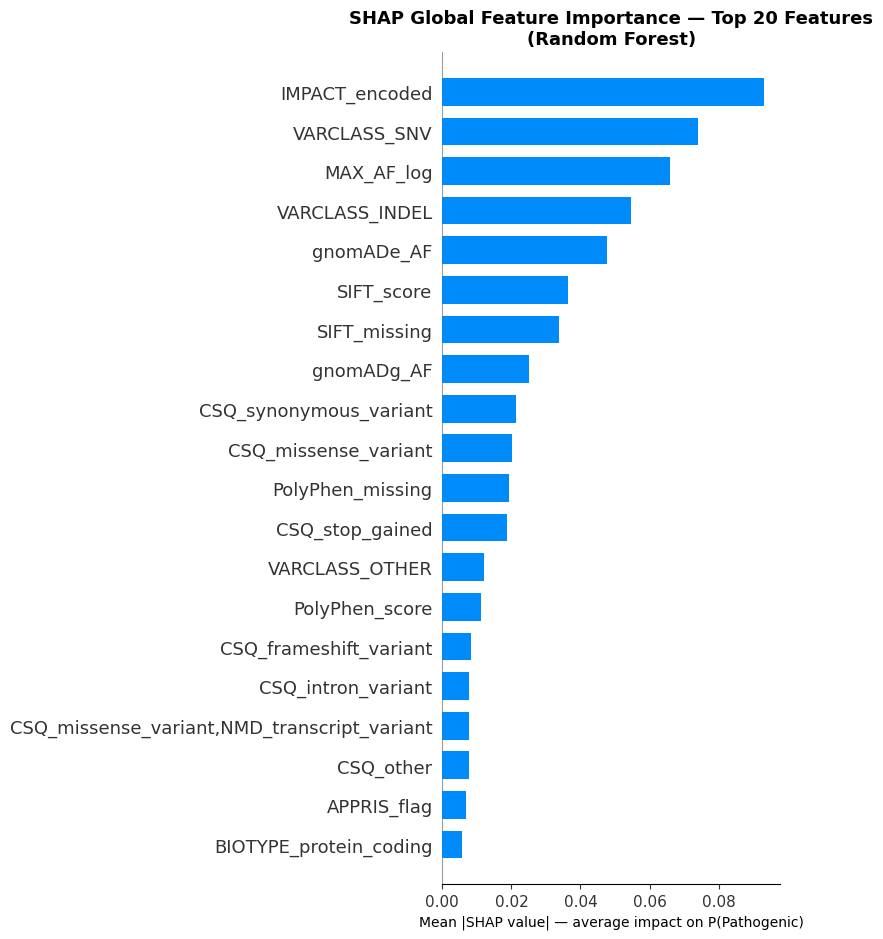

✅ Saved 20_shap_bar.png


In [4]:
plt.figure(figsize=(9, 7))
shap.summary_plot(
    shap_vals_path,
    X_shap,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title(f'SHAP Global Feature Importance — Top 20 Features\n({best_model_name})',
          fontsize=13, fontweight='bold')
plt.xlabel('Mean |SHAP value| — average impact on P(Pathogenic)', fontsize=10)
plt.tight_layout()
plt.savefig('20_shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved 20_shap_bar.png")

### Plot B: SHAP Beeswarm Plot *(primary manuscript figure)*

This is the most informative SHAP plot — it shows:
- **Which features matter most** (top = most important)
- **Direction of effect** (red = high feature value, blue = low)
- **Distribution of effects** across all samples

For example: if `MAX_AF_log` shows blue dots on the right (positive SHAP),
it means *low allele frequency pushes the model toward pathogenic* — biologically correct.

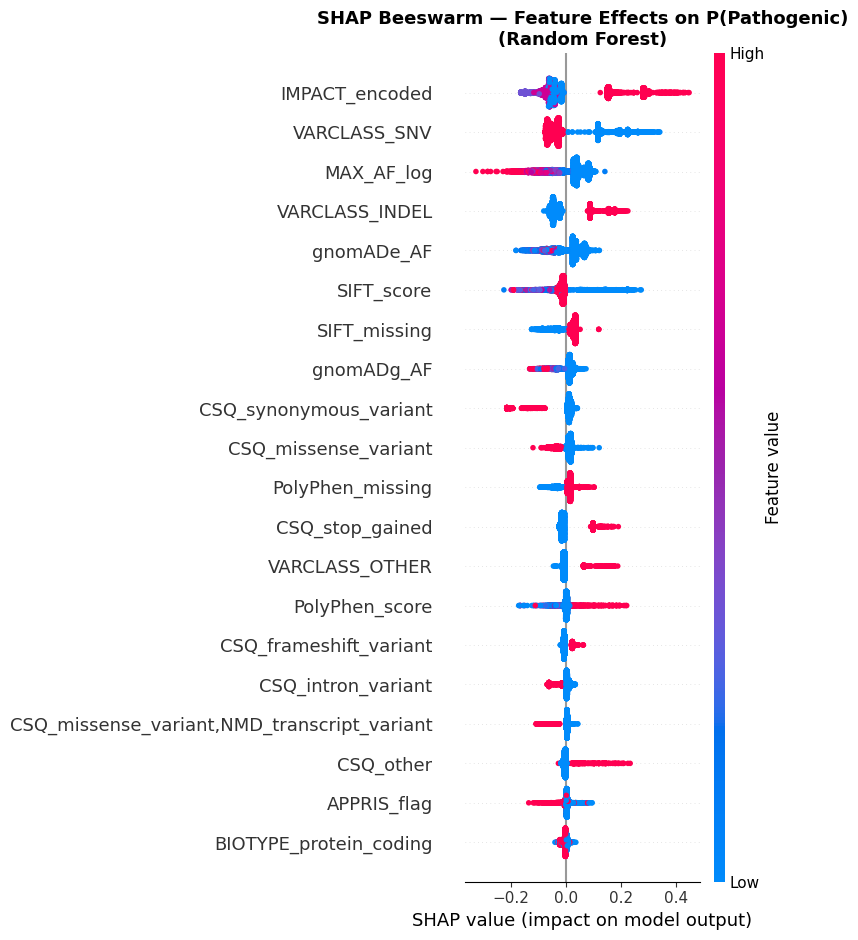

✅ Saved 21_shap_beeswarm.png

Reading the beeswarm:
  • Each dot = one variant
  • X position = SHAP value (how much it pushed toward/away from Pathogenic)
  • Colour = feature value (red=high, blue=low)
  • Width = density of variants at that SHAP value


In [5]:
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_vals_path,
    X_shap,
    max_display=20,
    show=False
)
plt.title(f'SHAP Beeswarm — Feature Effects on P(Pathogenic)\n({best_model_name})',
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('21_shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved 21_shap_beeswarm.png")
print()
print("Reading the beeswarm:")
print("  • Each dot = one variant")
print("  • X position = SHAP value (how much it pushed toward/away from Pathogenic)")
print("  • Colour = feature value (red=high, blue=low)")
print("  • Width = density of variants at that SHAP value")

## Step 5 — Dependence Plots for Top 3 Features

Dependence plots show **how a specific feature's value affects the model prediction**,
while also revealing interactions with a second feature (auto-selected by SHAP).

We plot the top 3 features by mean absolute SHAP.

Top 3 features for dependence plots: ['IMPACT_encoded', 'VARCLASS_SNV', 'MAX_AF_log']


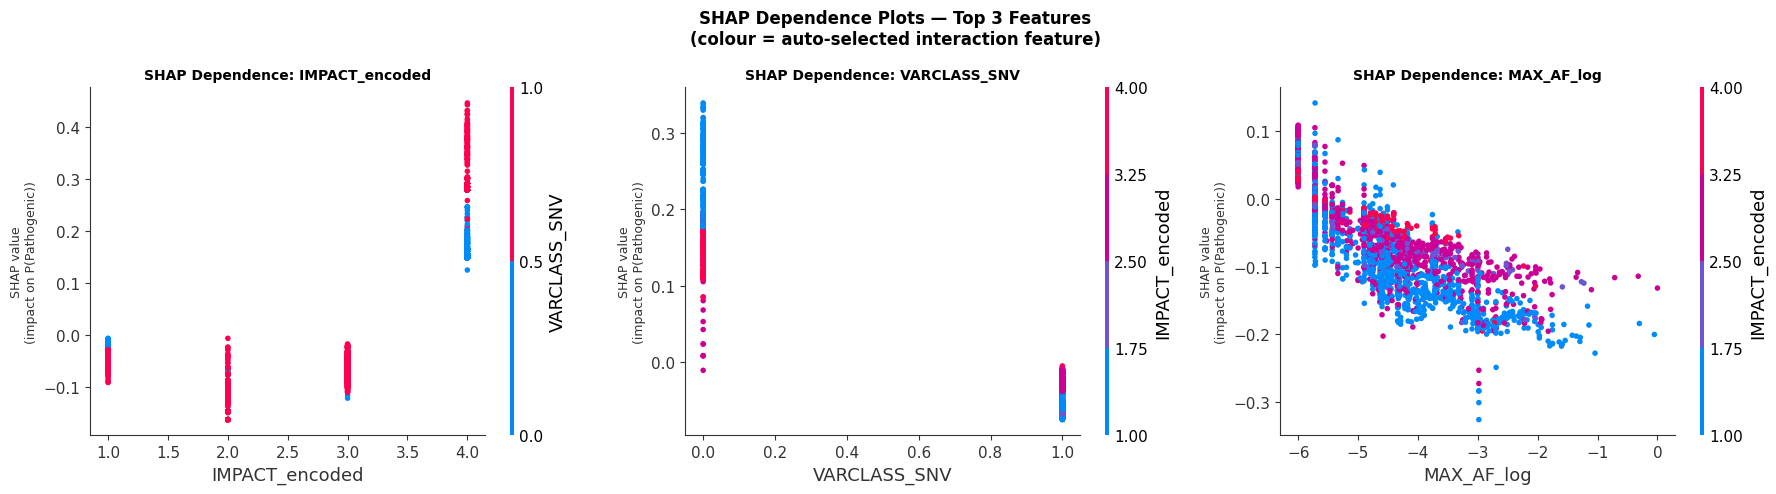

✅ Saved 22_shap_dependence.png


In [6]:
top3_features = mean_shap.head(3).index.tolist()
print("Top 3 features for dependence plots:", top3_features)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feat in zip(axes, top3_features):
    shap.dependence_plot(
        feat,
        shap_vals_path,
        X_shap,
        ax=ax,
        show=False
    )
    ax.set_title(f'SHAP Dependence: {feat}', fontsize=10, fontweight='bold')
    ax.set_ylabel(f'SHAP value\n(impact on P(Pathogenic))', fontsize=9)

plt.suptitle(
    'SHAP Dependence Plots — Top 3 Features\n'
    '(colour = auto-selected interaction feature)',
    fontsize=12, fontweight='bold'
)
plt.tight_layout()
plt.savefig('22_shap_dependence.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved 22_shap_dependence.png")

## Step 6 — Waterfall Plots: Individual Variant Explanations

Waterfall plots explain **a single variant's prediction** — showing exactly
which features pushed the model toward or away from pathogenic and by how much.

We show two clinically contrasting examples from the VUS set:
1. **Highest confidence Likely Pathogenic VUS** — why did the model flag this?
2. **Highest confidence Likely Benign VUS** — why did the model call this safe?

These are strong figures for the Discussion section of the manuscript.

Highest confidence Pathogenic : idx=31, P=0.9999
True label                    : Pathogenic

Non-zero features for this variant:
SIFT_score                                       0.5
SIFT_missing                                     1.0
PolyPhen_missing                                 1.0
IMPACT_encoded                                   4.0
MAX_AF_log                                      -6.0
CSQ_frameshift_variant,NMD_transcript_variant    1.0
BIOTYPE_NMD                                      1.0
VARCLASS_INDEL                                   1.0


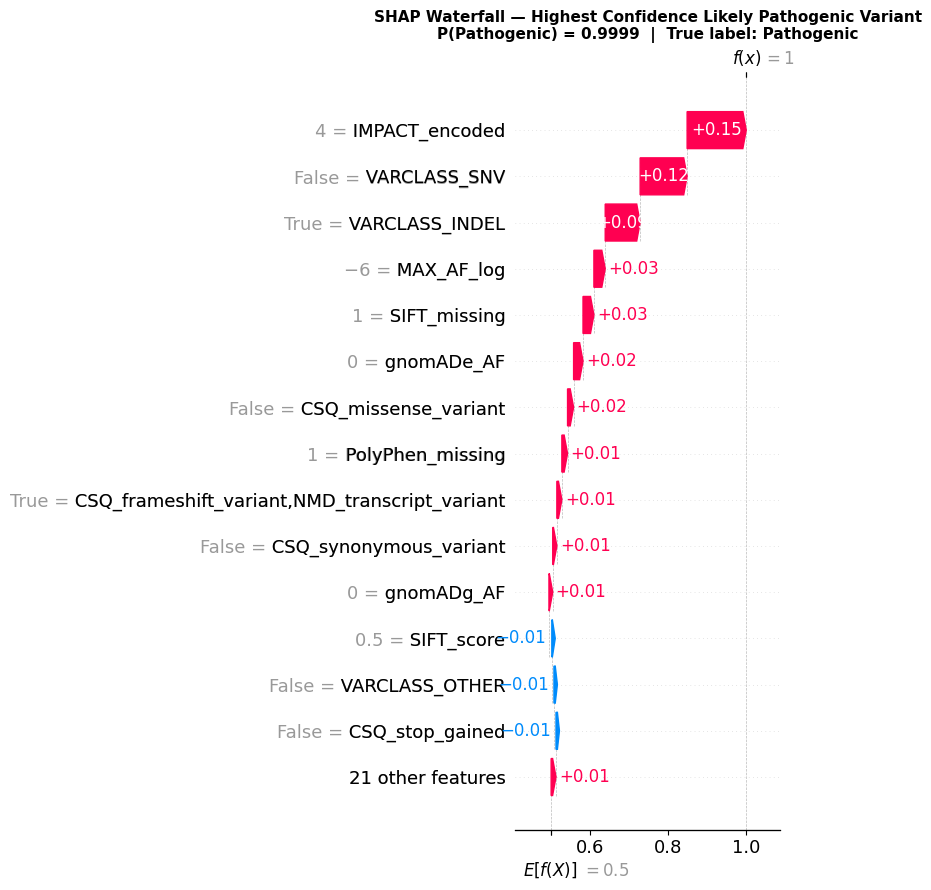

✅ Saved 23_shap_waterfall_pathogenic.png


In [9]:
## Step 6 — Waterfall Plots: Individual Variant Explanations

# ── Get predicted probabilities for the SHAP sample ──────────────────────────
probs_shap = best_model.predict_proba(X_shap)[:, 1]

# ══════════════════════════════════════════════════════════════════════════════
# Highest confidence Likely Pathogenic variant
# ══════════════════════════════════════════════════════════════════════════════
high_path_idx = np.argmax(probs_shap)
prob_high     = probs_shap[high_path_idx]

print(f"Highest confidence Pathogenic : idx={high_path_idx}, P={prob_high:.4f}")
print(f"True label                    : {'Pathogenic' if y_shap.iloc[high_path_idx]==1 else 'Benign'}")

# Safe feature display (handles bool/object dtype from get_dummies)
print("\nNon-zero features for this variant:")
try:
    variant_feats_num = X_shap.iloc[high_path_idx].astype(float)
    nonzero = variant_feats_num[variant_feats_num != 0]
    print(nonzero.round(4).to_string())
except Exception as e:
    print(f"  (Feature display skipped: {e})")
    print("  Raw values:")
    print(X_shap.iloc[high_path_idx].to_string())

# SHAP Explanation object 
shap_exp_path = shap.Explanation(
    values        = shap_vals_path[high_path_idx],
    base_values   = expected_val_path,
    data          = X_shap.iloc[high_path_idx].values,
    feature_names = feature_cols
)

#  Waterfall plot 
plt.figure(figsize=(11, 7))
shap.waterfall_plot(shap_exp_path, max_display=15, show=False)
plt.title(
    f'SHAP Waterfall — Highest Confidence Likely Pathogenic Variant\n'
    f'P(Pathogenic) = {prob_high:.4f}  |  True label: Pathogenic',
    fontsize=11, fontweight='bold'
)
plt.tight_layout()
plt.savefig('23_shap_waterfall_pathogenic.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved 23_shap_waterfall_pathogenic.png")


Highest confidence Benign : idx=2592, P=0.0008
True label                : Benign

Non-zero features for this variant:
SIFT_score                0.5000
SIFT_missing              1.0000
PolyPhen_missing          1.0000
IMPACT_encoded            2.0000
MAX_AF_log               -1.2700
gnomADe_AF                0.0010
gnomADg_AF                0.0108
APPRIS_flag               1.0000
CSQ_synonymous_variant    1.0000
BIOTYPE_protein_coding    1.0000
VARCLASS_SNV              1.0000


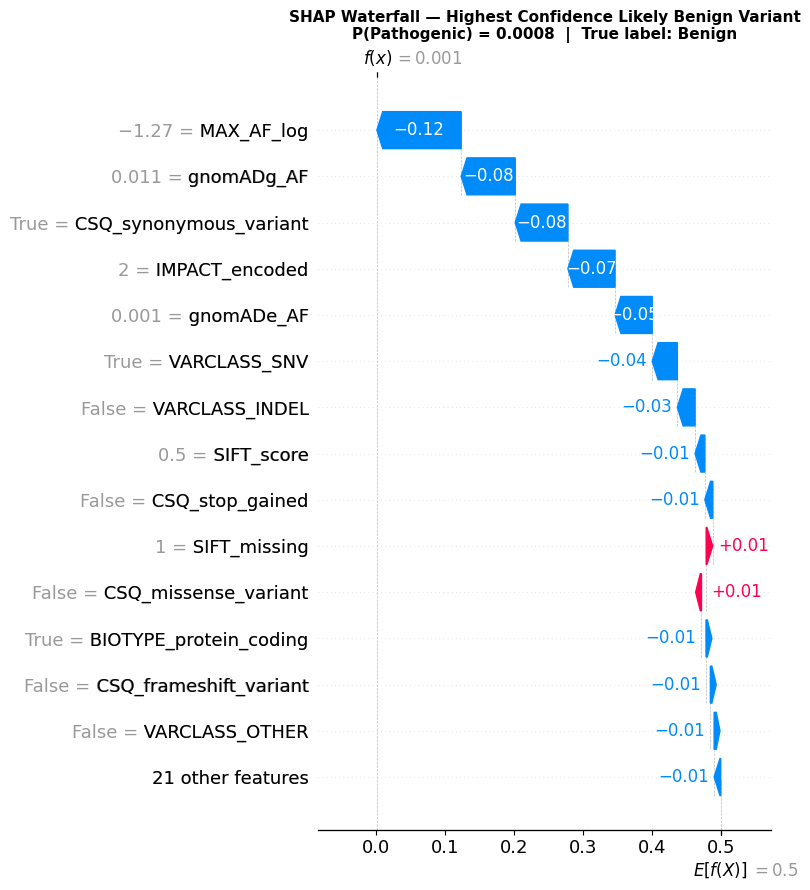

✅ Saved 24_shap_waterfall_benign.png


In [11]:
# Highest confidence Likely Benign variant 
high_ben_idx = np.argmin(probs_shap)
prob_low     = probs_shap[high_ben_idx]
print(f"Highest confidence Benign : idx={high_ben_idx}, P={prob_low:.4f}")
print(f"True label                : {'Pathogenic' if y_shap.iloc[high_ben_idx]==1 else 'Benign'}")

#Safe feature display (handles bool/object dtype from get_dummies) 
print("\nNon-zero features for this variant:")
try:
    variant_feats_num = X_shap.iloc[high_ben_idx].astype(float)
    nonzero = variant_feats_num[variant_feats_num != 0]
    print(nonzero.round(4).to_string())
except Exception as e:
    print(f"  (Feature display skipped: {e})")
    print("  Raw values:")
    print(X_shap.iloc[high_ben_idx].to_string())

# SHAP Explanation object 
shap_exp_ben = shap.Explanation(
    values        = shap_vals_path[high_ben_idx],
    base_values   = expected_val_path,
    data          = X_shap.iloc[high_ben_idx].values,
    feature_names = feature_cols
)

# Waterfall plot 
plt.figure(figsize=(11, 7))
shap.waterfall_plot(shap_exp_ben, max_display=15, show=False)
plt.title(
    f'SHAP Waterfall — Highest Confidence Likely Benign Variant\n'
    f'P(Pathogenic) = {prob_low:.4f}  |  True label: Benign',
    fontsize=11, fontweight='bold'
)
plt.tight_layout()
plt.savefig('24_shap_waterfall_benign.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved 24_shap_waterfall_benign.png")

## Step 7 — Biological Interpretation Summary

This cell prints a structured summary of the top SHAP features and their
biological interpretation — ready to adapt directly into the manuscript Results section.

In [12]:
# Mean SHAP and directionality per feature
# Positive mean SHAP = high feature value → pathogenic
# Negative mean SHAP = high feature value → benign

mean_shap_signed = pd.Series(
    shap_vals_path.mean(axis=0),
    index=feature_cols
).sort_values(key=abs, ascending=False)

mean_shap_abs = mean_shap_signed.abs().rename('mean_abs_shap')

df_shap_summary = pd.DataFrame({
    'mean_shap_signed' : mean_shap_signed,
    'mean_abs_shap'    : mean_shap_abs,
    'direction'        : mean_shap_signed.apply(
        lambda x: '→ Pathogenic when HIGH' if x > 0 else '→ Pathogenic when LOW'
    )
}).head(15)

print("=" * 70)
print(" TOP 15 FEATURES — MEAN SHAP + BIOLOGICAL DIRECTION")
print("=" * 70)
print(df_shap_summary.round(4).to_string())

df_shap_summary.to_csv('shap_feature_summary.csv')
print("\n✅ Saved shap_feature_summary.csv")

print()
print("=" * 70)
print(" BIOLOGICAL INTERPRETATION GUIDE")
print("=" * 70)
print("""
Expected biological directions (if model learned correctly):

  IMPACT_encoded      → Pathogenic when HIGH (HIGH impact = more likely pathogenic)
  MAX_AF / MAX_AF_log → Pathogenic when LOW  (rare variants = more likely pathogenic)
  SIFT_score          → Pathogenic when LOW  (low SIFT = more deleterious)
  PolyPhen_score      → Pathogenic when HIGH (high PolyPhen = more damaging)
  VARCLASS_INDEL      → Pathogenic when HIGH (indels = frameshifts = pathogenic)
  CSQ_frameshift      → Pathogenic when HIGH (frameshift = loss of function)
  CSQ_stop_gained     → Pathogenic when HIGH (premature stop = loss of function)
  CSQ_missense        → mixed signal (missense can be path or benign)
  CSQ_synonymous      → Pathogenic when LOW  (synonymous = typically benign)
  gnomADe_AF          → Pathogenic when LOW  (population frequency)

Check the beeswarm plot (21_shap_beeswarm.png) to verify these directions
in your actual model. Any unexpected direction should be discussed in the manuscript.
""")

 TOP 15 FEATURES — MEAN SHAP + BIOLOGICAL DIRECTION
                        mean_shap_signed  mean_abs_shap               direction
VARCLASS_INDEL                   -0.0094         0.0094   → Pathogenic when LOW
SIFT_score                       -0.0084         0.0084   → Pathogenic when LOW
MAX_AF_log                       -0.0073         0.0073   → Pathogenic when LOW
SIFT_missing                      0.0054         0.0054  → Pathogenic when HIGH
CSQ_stop_gained                  -0.0047         0.0047   → Pathogenic when LOW
CSQ_synonymous_variant            0.0043         0.0043  → Pathogenic when HIGH
VARCLASS_SNV                      0.0036         0.0036  → Pathogenic when HIGH
CSQ_frameshift_variant           -0.0035         0.0035   → Pathogenic when LOW
CSQ_missense_variant              0.0030         0.0030  → Pathogenic when HIGH
VARCLASS_OTHER                   -0.0030         0.0030   → Pathogenic when LOW
PolyPhen_missing                  0.0028         0.0028  → Pathogeni